Suppose we have the data:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from utils.config_jupyter_notebooks import *
from utils.generative_models import *

L :  1.99951171875  vs length of windows  2  source: config_jupyter_notebooks  vs distances of time domain strip:  (0.00024411081903918935,)  which should equal  0.00024411081903918935
Important variables: 
		signal_strip_time, signal_strip_strain 
		signal_strip_strain_tapered
		strain
		time_domain_strip
		N


L :  1.99951171875  vs length of windows  2  source: config_jupyter_notebooks  vs distances of time domain strip:  (0.00024411081903918935,)  which should equal  0.00024411081903918935
Important variables: 
		signal_strip_time, signal_strip_strain 
		signal_strip_strain_tapered
		strain
		time_domain_strip
		N




In [3]:
strain_values = strain.value * 1e19

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


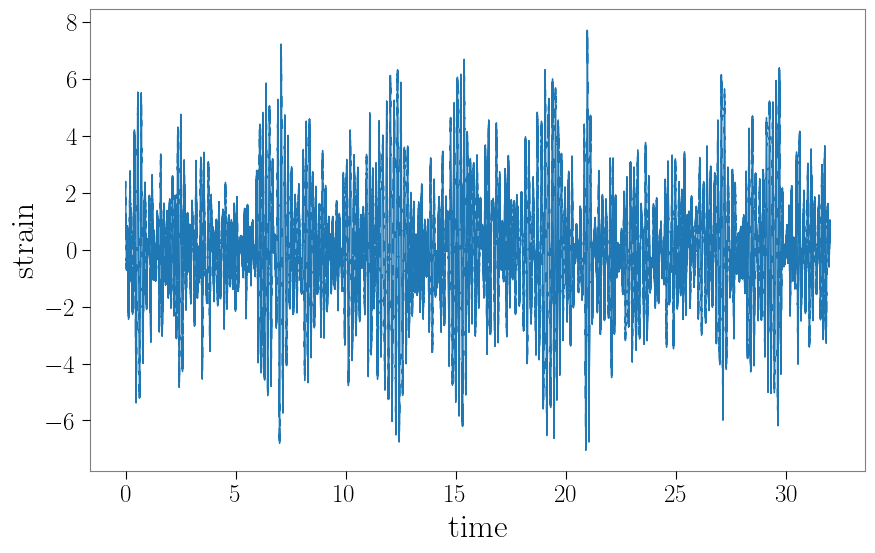

In [4]:
plt.plot(time, strain_values)
usual_plot()

How can we be sure that the signal is in the marked window?
When the signal "kicks in" we would expect the two-point statistics of the time series to change, even if the noise and or signal were non-stationary and non-Gaussian. So let's analyze the change in the 2-point-statistic, approximated by the "sample autocovariance function" over different time windows:

$$C(x, l)=\frac{1}{n}\sum_{t=0}^{n-l-1} (x_{t+l}-\bar{x})\cdot (x_t-\bar{x})$$

This approximately computes the correlation between all pairs of data that are spaced $$l$$ apart. Source: Berkeley statistics lecture, https://www.stat.berkeley.edu/~bartlett/courses/153-fall2010/lectures/4.pdf.


In [5]:
def C(x:np.array, l:int):
    """

    :param x:   The window to calculate the l-autocovariance for.
    :param l:   The lag to calculate the l-autocovariance for.
    :return:
    """
    n = len(x)
    if l == n:
        raise ValueError("l should be at most n-1 and take on values 0,..,n-1")
    x_bar = np.mean(x)
    to_sum = []
    for t in range(n-l):  # range such that x_2 is at most x[(n-l-1) + l] = x[n-1]! ( n-l-1 == max(range(n-l)) )
        x_1 = x[t]
        x_2 = x[t+l]
        tmp = (x_1-x_bar)*(x_2-x_bar)
        to_sum.append(tmp)
    return 1/(n-l) * np.sum(to_sum)

# We may calculate a vector for each window of length n-1:
def get_C_vector(x:np.array):
    """
    Gets a vector [C(x,l) for all l in [0,...,n-1]]
    :param x:   The window to analyze
    :return:
    """
    n = len(x)
    res = []
    for l in range(n):
        res.append(C(x, l))
    return np.array(res)

def get_C_vector_fast(x: np.ndarray) -> np.ndarray:
    """
    A chatGpt vectorized implementation of get_C_vector.
    Vectorized computation of empirical autocovariance for all lags.
    Returns C(l) for l = 0, ..., n-1
    """
    x = x - np.mean(x)
    n = len(x)
    return np.array([
        np.dot(x[:n - l], x[l:]) / (n - l)
        for l in range(n)
    ])


Let's cut-up the data into little windows. We truncate the time series such that its length is divisible by the window length.

In [6]:
def divisor(t: np.array, x: np.array, window_length: float):
    """
    Subdivides a given (x, t) time series into non-overlapping windows of duration `window_length` (in seconds).
    Assumes t is sorted and uniformly sampled.

    :param x:               The time series values.
    :param t:               The time stamps (1D array, same length as x).
    :param window_length:   Window length in seconds.
    :return:                Tuple of (windows of t, windows of x), both shaped (num_windows, samples_per_window)
    """
    dt = t[1] - t[0]  # assume uniform sampling
    samples_per_window = int(window_length / dt)

    total_samples = len(t)
    usable_samples = (total_samples // samples_per_window) * samples_per_window

    x = x[:usable_samples]
    t = t[:usable_samples]

    res_x = x.reshape(-1, samples_per_window)
    res_t = t.reshape(-1, samples_per_window)

    return res_t, res_x



def divisor_unit_test():
    x = np.linspace(1, 8, 6)
    t = np.linspace(2, 10, 6)  # dt = 1.6, so 2 samples = 3.2s
    wl = 3.2  # seconds → 2 samples

    res_t, res_x = divisor(x, t, wl)

    expected_t = np.array([[2., 3.6], [5.2, 6.8], [8.4, 10.]])
    expected_x = np.array([[1., 2.4], [3.8, 5.2], [6.6, 8.]])

    assert np.allclose(res_t, expected_t), "Time values do not match"
    assert np.allclose(res_x, expected_x), "Data values do not match"
    print("Test passed!")





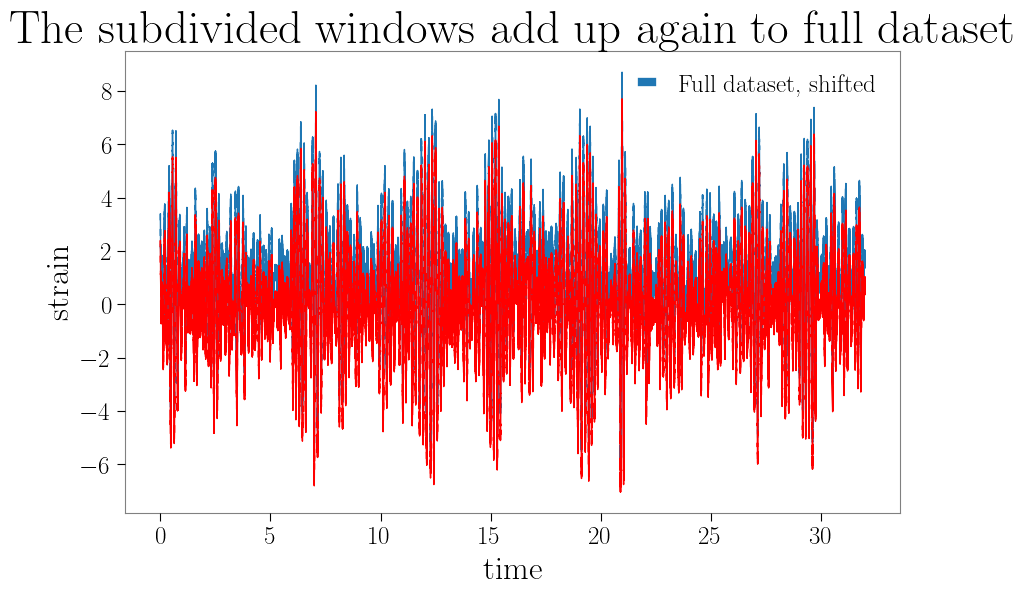

In [7]:
div_object = divisor(time, strain_values, window_length=0.5)
time_windows = div_object[0]
strain_windows = div_object[1]

plt.plot(time, strain_values+1, label="Full dataset, shifted")
for t, s in zip(time_windows, strain_windows):
    plt.plot(t, s, color="red")

usual_plot(title="The subdivided windows add up again to full dataset")


In [8]:
C_matrix = np.array([get_C_vector_fast(s) for s in strain_windows])

# test1 = get_C_vector_fast(strain_windows[0])
# test2 = get_C_vector(strain_windows[0]) # => np.allclose(test1, test2) is True!


In [9]:
print("Number of windows", len(strain_windows))
print("Length of one C(x,l) vector", len(C_matrix[0]))
C_matrix.shape  # must be (num_windows, length c_vector)

Number of windows 64
Length of one C(x,l) vector 2048


(64, 2048)

In [10]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2).fit(C_matrix)
labels = gmm.predict(C_matrix)

In [11]:
# kmeans = KMeans(n_clusters=2, random_state=0)
# labels = kmeans.fit_predict(C_matrix)

In [12]:
print(labels)
idcs_where_possibly_signal = np.where(np.array(labels) == 1)
print("time windows that could correspond to a signal:\n\n ")

for time_window in time_windows[idcs_where_possibly_signal]:
    print(min(time_window), "->", max(time_window))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
time windows that could correspond to a signal:

 
7.0 -> 7.499755859375
11.5 -> 11.999755859375
12.0 -> 12.499755859375
15.0 -> 15.499755859375
19.0 -> 19.499755859375


Ok that didn't really work. What if we cross-correlate H1 and L1 data?

In [13]:

strain_object_L1 = unpickle_me_this("data/GW150914_strain_L1.pickle")
time_H1 = time
strain_H1 = strain_values

time_L1 = np.array(strain_object_L1.times) - zero_time
strain_L1 = strain_object_L1.value * 1e19

Note: The L1 strain is centered on a negative value. Physical reason is not known to me. But this is the expected behaviour, see: https://gwpy.github.io/docs/latest/timeseries/opendata/


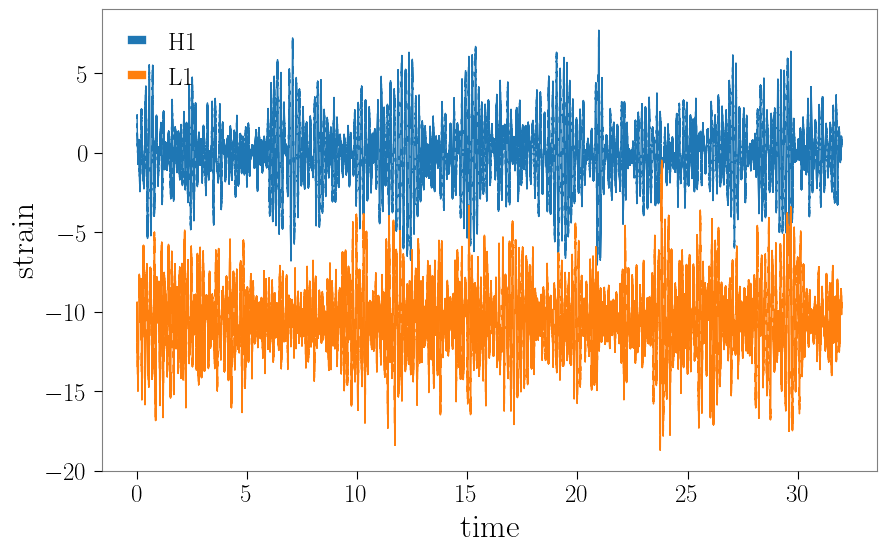

In [14]:

print("Note: The L1 strain is centered on a negative value. Physical reason is not known to me. But this is the expected behaviour, see: https://gwpy.github.io/docs/latest/timeseries/opendata/")

plt.plot(time_H1, strain_H1, label="H1")
plt.plot(time_L1, strain_L1, label="L1")
usual_plot()

Now let's cross-correlate these two data strips and see what happens. The cross-correlation at some time lag (so the covariance in between data sets of points that are separated by $\tau$ apart) should be:

$$R(\tau)= \frac{1}{n-|\tau|} \sum_{i=0}^{n-|\tau|-1} (H_1 - \langle H_1 \rangle)(t_i)\cdot (L_1  - \langle L_1 \rangle)(t_i+\tau)$$

with $n=\texttt{len}(H_1)==\texttt{len}(L_1)$. By this definition, $\tau$ needs to be an integer and can maximally be $n-1$. Due to symmetry of the covariance I think $\tau$ is allowed to be from the range $\tau \in \{n-1, ... n+1\}$, which is why I put absolute values around the $\tau$'s in the above formula.

In [15]:

def covariance(h1: np.ndarray, h2: np.ndarray, max_lag: int = None) -> tuple:
    """
    Compute full cross-correlation manually between two signals.
    Returns correlation vector and corresponding lags.

    :param h1: First signal (1D array)
    :param h2: Second signal (1D array, same length)
    :param max_lag: Maximum lag (default = len(h1) - 1)
    :return: (correlations, lags)
    """
    assert len(h1) == len(h2), "Signals must be the same length"
    N = len(h1)
    if max_lag is None:
        max_lag = N - 1

    h1 = h1 - np.mean(h1)
    h2 = h2 - np.mean(h2)

    lags = np.arange(-max_lag, max_lag + 1)
    corr = []

    for tau in lags:
        if tau < 0:
            # h1[t - tau] * h2[t]
            t_range = range(-tau, N)
            c = sum(h1[t + tau] * h2[t] for t in t_range)
            c /= len(t_range)
        else:
            # h1[t] * h2[t + tau]
            t_range = range(0, N - tau)
            c = sum(h1[t] * h2[t + tau] for t in t_range)
            c /= len(t_range)
        corr.append(c)

    corr /= np.max(corr)
    return lags, np.array(corr)


def covariance_fast(h1: np.ndarray, h2: np.ndarray, max_lag: int = None) -> tuple:
    """
    Fast normalized cross-covariance using numpy.correlate.
    Returns lags and normalized covariance vector.

    :param h1: First signal
    :param h2: Second signal
    :param max_lag: Max lag (default: full)
    :return: (lags, normalized covariance)
    """
    assert len(h1) == len(h2), "Signals must be the same length"
    N = len(h1)

    # Detrend
    h1 = h1 - np.mean(h1)
    h2 = h2 - np.mean(h2)

    # Full cross-correlation
    full_corr = np.correlate(h1, h2, mode='full') / N

    # Compute lags
    full_lags = np.arange(-N + 1, N)

    # Select only within desired max_lag
    if max_lag is not None:
        mask = np.abs(full_lags) <= max_lag
        full_corr = full_corr[mask]
        full_lags = full_lags[mask]

    # Normalize to max 1
    # full_corr /= np.max(np.abs(full_corr))

    return full_lags, full_corr

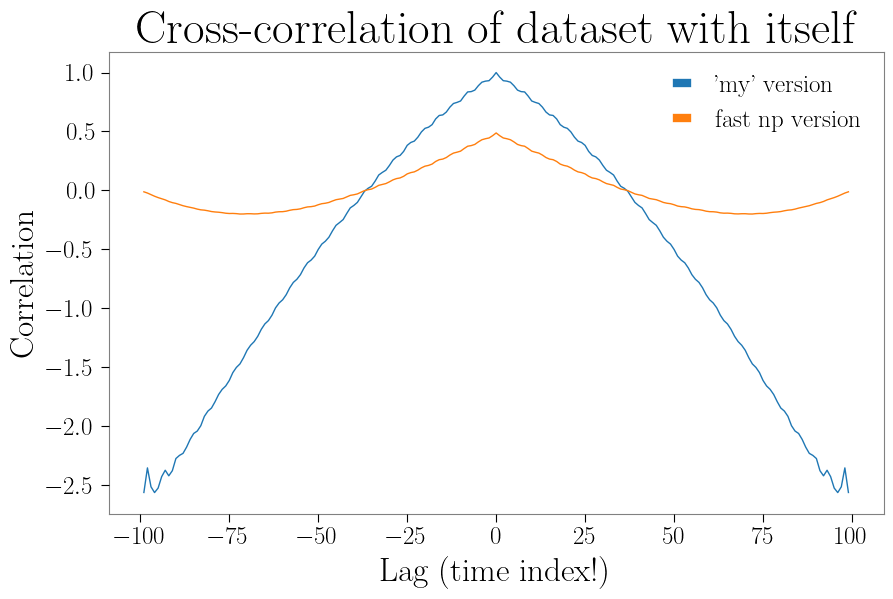

In [16]:

subset1 = strain_H1[:100]
subset2 = strain_H1[:100]

lags_subset_1, corr_subset_1 = covariance(subset1, subset2)
lags_subset_2, corr_subset_2 = covariance_fast(subset1, subset2)

plt.plot(lags_subset_1, corr_subset_1, label="'my' version")
plt.plot(lags_subset_2, corr_subset_2, label="fast np version")
usual_plot(xl="Lag (time index!)", yl="Correlation", title="Cross-correlation of dataset with itself")
plt.show()


In [17]:
sampling_rate = 1/(time_H1[1] - time_H1[0])
max_lag = 10*int(np.ceil(0.010 * sampling_rate))  # 10 ms in samples...

print("Time: ", time_H1[10000], " (event at ~16.4) ")
lags, corr = covariance_fast(strain_L1[:10000], strain_H1[:10000])

Time:  2.44140625  (event at ~16.4) 


The sampling rate is:  4096.0
I have no clue how to interpret this plot.


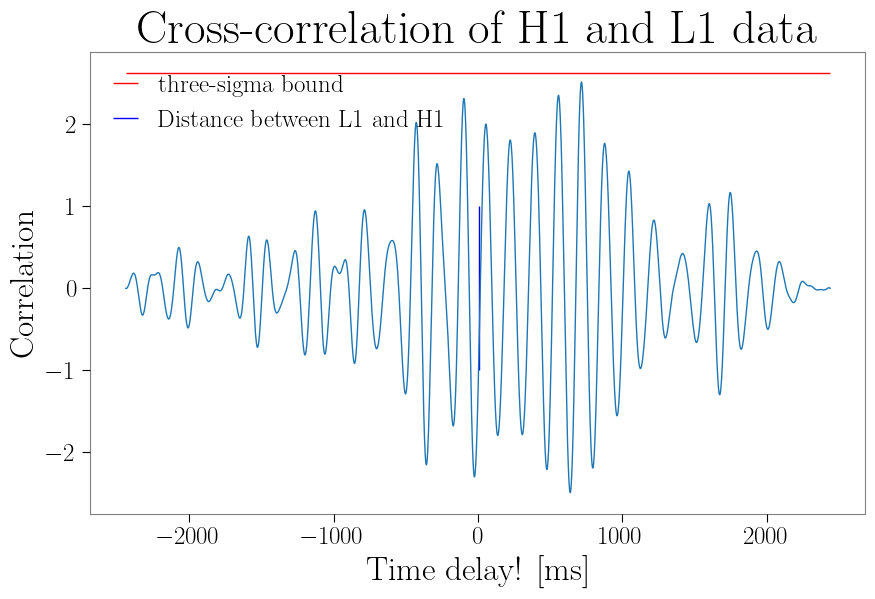

In [18]:
three_sigma_bound = 3*np.std(corr)
print("The sampling rate is: ", sampling_rate)

print("I have no clue how to interpret this plot.")

x_vals = 1000*lags/sampling_rate

plt.hlines(three_sigma_bound, np.min(x_vals), np.max(x_vals), label="three-sigma bound", color="red")
plt.vlines(10, -1, 1, label="Distance between L1 and H1")

plt.plot(x_vals, corr)

usual_plot(xl=r"Time delay! $\mathrm{[ms]}$", yl="Correlation", title="Cross-correlation of H1 and L1 data")

Let's re-do this analysis in a per-window basis.

In [19]:
wl = 0.01

div_object_l1 = divisor(time_L1, strain_L1, window_length=wl)
div_object_h1 = divisor(time_H1, strain_H1, window_length=wl)

time_windows_l1 = div_object_l1[0]
strain_windows_l1 = div_object_l1[1]

time_windows_h1 = div_object_h1[0]
strain_windows_h1 = div_object_h1[1]

results = []

for idx, (h1_window, l1_window) in enumerate(zip(strain_windows_h1, strain_windows_l1)):
    lags, c = covariance_fast(h1_window, l1_window)
    max_corr_idx = np.argmax(np.abs(c))
    max_corr_val = c[max_corr_idx]
    lag_at_max = lags[max_corr_idx]
    time_of_window = idx * wl  # in seconds

    results.append((time_of_window, lag_at_max, max_corr_val))


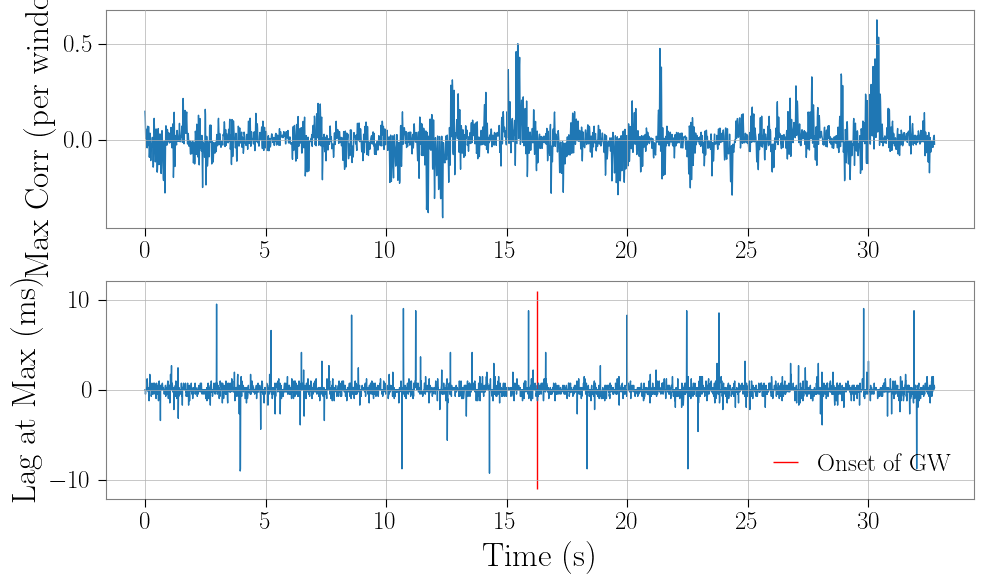

In [20]:
times = [r[0] for r in results]
lags = [r[1] / sampling_rate * 1000 for r in results]  # convert lag to milliseconds
corrs = [r[2] for r in results]

plt.subplot(2,1,1)
plt.plot(times, corrs)
plt.ylabel("Max Corr (per window)")
plt.grid()

plt.subplot(2,1,2)
plt.vlines(16.25, -11,11, color="red", label="Onset of GW")
plt.plot(times, lags)
plt.ylabel("Lag at Max (ms)")
plt.xlabel("Time (s)")
plt.grid()

plt.legend()
plt.tight_layout()
plt.show()

This is still not what I'm looking for. Let's recreate the plot from the file `matched_filterin_action.ipynb`

In [21]:
def cross_correlate(d1, d2):
    """finds the cross-correlation between two arrays d1 and d2"""
    return plt.xcorr(d1, d2, maxlags=len(d1) - 1)

def get_correlation(H1_data, L1_data, time, t_min, t_max):
    """obtains the cross correlation between the H1 and L1 strain data arrays,
    limited to times in between t_min and t_max of the corresponding time array.

    Args:
        H1_data (ndarray): H1 strain data
        L1_data (ndarray): L1 strain data
        time (ndarray): Time corresponding to both H1 and L1 data.
        t_min (float): Minimum time for data cross-correlation
        t_max (float): Maximum time for data cross-correlation

    Returns:
        ndarray: cross-correlation values obtained
        ndarray: time shifts for the given correlation values
    """
    # we're only doing this between t_min and t_max
    time_int = np.where((time >= t_min) & (time <= t_max))
    H1_int = H1_data[time_int]
    L1_int = L1_data[time_int]

    correlation = cross_correlate(H1_int, L1_int)
    lags = correlation[0]
    corr = correlation[1]
    # here we have one correlation value for each possible lag, total amount is
    # 2 * len(t_int)
    interval_len = (t_max - t_min)
    time_diffs = np.linspace(-1 * interval_len, interval_len, len(corr))
    return corr, time_diffs

In [22]:

H1_original_paper_wh_bp = np.loadtxt("data/H1-wh-bp-original_paper.txt")
L1_original_paper_wh_bp = np.loadtxt("data/L1-wh-bp-original_paper.txt")
time_original_paper = np.loadtxt("data/time-original_paper.txt")


H1_updated_paper_wh_bp = np.loadtxt("data/H1-wh-bp-updated_paper.txt")
L1_updated_paper_wh_bp = np.loadtxt("data/L1-wh-bp-updated_paper.txt")
time_updated_paper = np.loadtxt("data/time-updated_paper.txt")

print(len(H1_updated_paper_wh_bp), len(L1_updated_paper_wh_bp), len(time_updated_paper))
print(len(H1_original_paper_wh_bp), len(L1_original_paper_wh_bp), len(time_original_paper))
print("time_original_paper: ", time_original_paper)
print("time_updated_paper: ", time_updated_paper)


3441 3441 3441
131072 131072 131072
time_original_paper:  [1.12625945e+09 1.12625945e+09 1.12625945e+09 ... 1.12625948e+09
 1.12625948e+09 1.12625948e+09]
time_updated_paper:  [0.25       0.25006104 0.25012207 ... 0.45983887 0.4598999
 0.45996094]


min max:  16.2001953125 16.499755859375


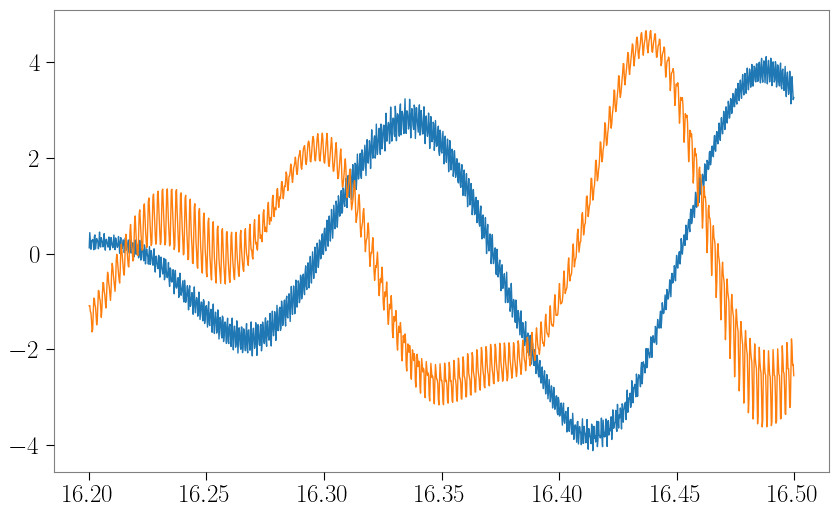

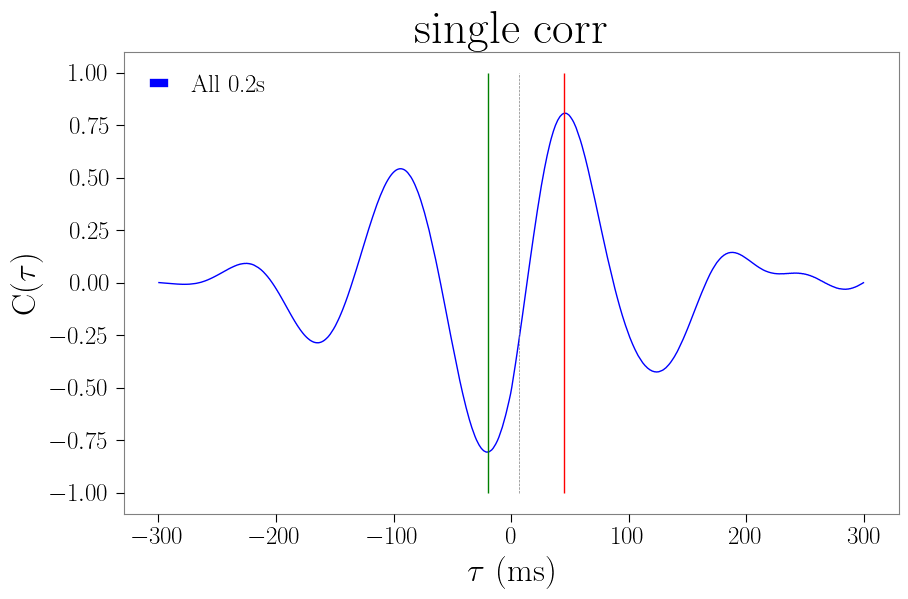

In [27]:

def cross_correlate(d1, d2):
    """finds the cross-correlation between two arrays d1 and d2"""
    return plt.xcorr(d1, d2, maxlags=len(d1) - 1)

def get_correlation(H1_data, L1_data, time, t_min, t_max):
    """obtains the cross correlation between the H1 and L1 strain data arrays,
    limited to times in between t_min and t_max of the corresponding time array.

    Args:
        H1_data (ndarray): H1 strain data
        L1_data (ndarray): L1 strain data
        time (ndarray): Time corresponding to both H1 and L1 data.
        t_min (float): Minimum time for data cross-correlation
        t_max (float): Maximum time for data cross-correlation

    Returns:
        ndarray: cross-correlation values obtained
        ndarray: time shifts for the given correlation values
    """
    # we're only doing this between t_min and t_max
    time_int = np.where((time >= t_min) & (time <= t_max))
    H1_int = H1_data[time_int]
    L1_int = L1_data[time_int]

    correlation = cross_correlate(H1_int, L1_int)
    lags = correlation[0]
    corr = correlation[1]
    # here we have one correlation value for each possible lag, total amount is
    # 2 * len(t_int)
    interval_len = (t_max - t_min)
    time_diffs = np.linspace(-1 * interval_len, interval_len, len(corr))
    return corr, time_diffs


def run_cross_corrs(orig_H1, orig_L1,
                    orig_time, t0, tmin=.25, tmax=.46):
    """Runs 4 different cross correlations for the H1, L1 residual data and time,
    the H1, L1 original strain data and time: Full interval, first half, last
    half, and .39-43s.

    Args:
        orig_H1 (ndarray): original H1 strain data from event
        orig_L1 (ndarray): original L1 strain data from event
        orig_time (ndarray): time corresponding to orig data
        t0 (float): starting time of time interval
        tmin (float): starting time of full correlation interval (i.e. which min time at which to start the correlation)
        tmax (float): ending time of full correlation interval (max time to start the correlation)

    Returns:
        dict: dictionary containing residual correlation values, whose keys
            are the various time intervals
        dict: dictionary containing original strain correlation values, whose
            keys are the various time intervals
    """
    # define 4 different intervals for cross correlation
    intervals = {'All 0.2s': (t0 + tmin, t0 + tmax)}
    # intervals = {'All 0.2s': (t0 + s, t0 + e), 'Last half': (t0 + s + .1, t0 + e),
    #             'First half': (t0 + s, t0 + s + .1), '0.39s-0.43s': (t0 + .39, t0 + .43)}

    resid_correlation_vals = {}
    original_correlation_vals = {}
    # go through and calculate for each interval
    for key in intervals.keys():
        interval = intervals[key]
        detrend_orig_H1 = orig_H1 - np.mean(orig_H1)
        detrend_orig_L1 = orig_L1 - np.mean(orig_L1)
        plt.plot(orig_time, detrend_orig_H1)
        plt.plot(orig_time, detrend_orig_L1)
        plt.show()
        orig_corr = get_correlation(detrend_orig_H1, detrend_orig_L1, orig_time, interval[0],
                                    interval[1])
        original_correlation_vals[key] = orig_corr

    return original_correlation_vals

# fig_observed_correlation_vals = run_cross_corrs(H1_original_paper_wh_bp, L1_original_paper_wh_bp, time_original_paper, t0=1126259462)
# better_correlation_vals = run_cross_corrs(H1_updated_paper_wh_bp, L1_updated_paper_wh_bp, time_updated_paper, t0=0)

idcs_of_event = np.where((time_H1>16.2) & (time_H1<16.5))
strain_L1_in_significant_interval = strain_L1[idcs_of_event]
strain_H1_in_significant_interval = strain_H1[idcs_of_event]
time_in_significant_interval = time[idcs_of_event]

print("min max: ", np.min(time_in_significant_interval), np.max(time_in_significant_interval))

myCorrelationVals = run_cross_corrs(strain_H1_in_significant_interval, strain_L1_in_significant_interval, time_in_significant_interval, t0=0, tmin=np.min(time_in_significant_interval), tmax=np.max(time_in_significant_interval))

def plot_correlation_vals_axis(correlation_vals, ax):
    """Plots correlations values obtained on a given axis object."""
    colors = {'All 0.2s': 'blue'}
    # colors = {'First half': 'black', 'Last half': 'red', 'All 0.2s': 'blue',
    #           '0.39s-0.43s': 'green'}
    if ax is None:
        fig, ax = plt.subplots()
    for key in correlation_vals.keys():
        corr = correlation_vals[key]
        # plot in ms instead of s
        ax.plot(corr[1] * 1000, corr[0], colors[key], label=key)

    yVals = np.linspace(-1, 1, 1000)
    ax.plot([7] * 1000, yVals, '--', color='gray', linewidth=.5)
    # ax.set_xlim(-20, 20)
    # ax.set_ylim(-1, 1)
    ax.set_ylabel(r'C($\tau$)')
    ax.set_xlabel(r'$\tau$ (ms)')
    ax.legend(loc='upper left')



corr_vals = [myCorrelationVals]
# corr_vals = [fig_observed_correlation_vals, better_correlation_vals]
plt.close()

# titles = ['Fig. 1 PRL original data', 'This Paper whitened and bp']
titles = ['This Paper whitened and bp']

def single_corr_plot(corr_val, title):
    plot_correlation_vals_axis(corr_val, None)
    plt.title(title)
    plt.vlines(45, -1, 1, color="red")
    plt.vlines(-20, -1, 1, color="green")
    plt.show()

# def plot_subplot(corr_vals, titles):
#     """Plots correlation values and titles on the same subplot."""
#     fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
#     fig.subplots_adjust(hspace=0)
#     for i, ax in enumerate(axes):
#         plot_correlation_vals_axis(corr_vals[i], ax)
#         ax.set_title(titles[i])


single_corr_plot(corr_vals[0], title="single corr")

moving L1 samples to the right:  -82
 signal does not seem to correlate at all in the probable signal interval.. the max delay between the signal should be 10ms, i.e. a tenth of the unit on the x axis.


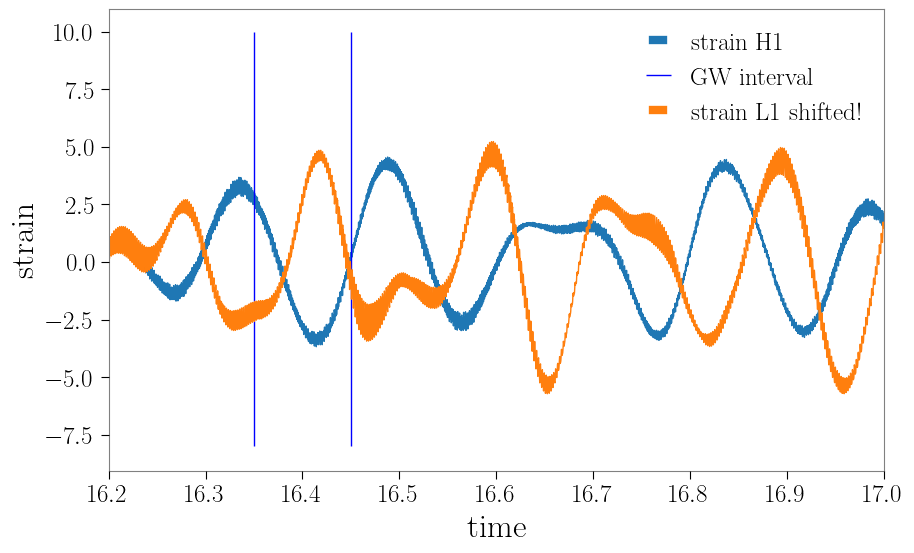

In [24]:
plt.plot(time_H1, strain_H1, label="strain H1")

physical_time_to_shift =  -0.02 # 0.05 # 10*1e-3 expected from whitened and bandpassed shift...
samples_to_shift = int(np.round(physical_time_to_shift*sampling_rate,0)) # delay /(sampling rate) = physical_time

print("moving L1 samples to the right: ", samples_to_shift)

L1_detrend = strain_L1-np.mean(strain_L1)
shifted_L1 = np.roll(L1_detrend, samples_to_shift, axis=0)

plt.vlines([16.4-0.05,16.4+0.05], -8,10, color="blue", label="GW interval")

plt.plot(time_L1, shifted_L1, label="strain L1 shifted!")
plt.xlim(16.2,17)
comment = (" signal does not seem to correlate at all in the probable signal interval.. the max delay between the signal should be 10ms, i.e. a tenth of "
           "the unit on the x axis.")
print(comment)
usual_plot()